<img style="float:right; width:20%" src="logogach.png" />

# Modelo de epidemia basado en tasa de reproducción.


## Proyecciones de corto plazo


### Andrés Ferragut
### Universidad ORT Uruguay y GACH - Área Datos

## El modelo de Cori et al. 2013

En el artículo [Cori et al. 2013](https://www.ncbi.nlm.nih.gov/pubmed/24043437) se describe el siguiente modelo para estimar la reproducción de una epidemia en base a datos de incidencia diaria.

Consideremos una población en la que un virus se propaga. Para modelar la contagiosidad del mismo, utilizamos el intervalo serial (Serial Interval) $\{w_s\}$ $s>0$.

**Idea:** Si voy a contagiar a alguien, cuán probable es que lo haga el día $s=1,2,\ldots$. Notar que $w_s$ es una distribución de probabilidad ($\sum_{s=1}^\infty w_s = 1$).

### Ejemplo: shifted Gamma (Cori et. al)

Cori et al. proponen para el SI una distribución Gamma trasladada y discretizada. Tomando por ejemplo $\mu=3.95$, $\sigma = 4.75$ (valores para COVID de  [Du et al](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)) tenemos:

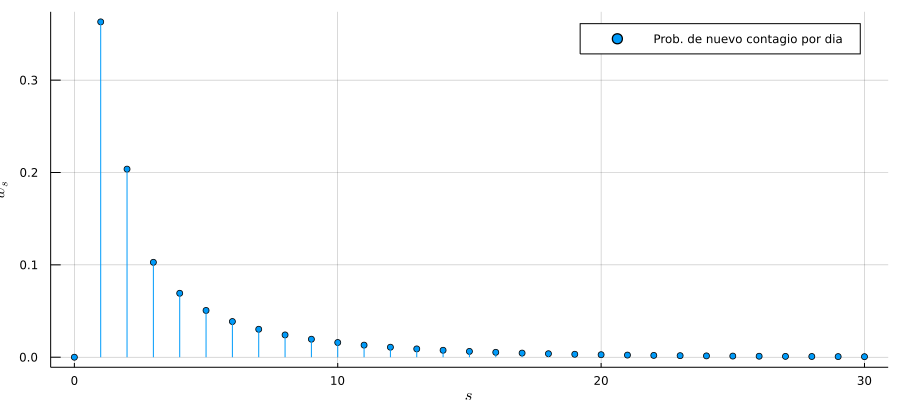

In [2]:
#Paquetes
using Distributions, Plots, LaTeXStrings, EpiSim
default(size=(900,400), gridalpha=0.3)

T=30
w=si_covid.((0:T))
plot((0:T),w , xlabel=L"s", ylabel=L"w_s", lt=:stem, marker=:circle, label="Prob. de nuevo contagio por dia")

### El parámetro $R$ y la reproducción del virus.

Supongamos que una persona que se infecta el día $t$, puede generar nuevas infecciones en días subsiguientes como:

$$N_{t+s}^0 \sim Poisson(Rw_{s}),$$

independientes para cada día. Aquí $R$ es un parámetro que mide el crecimiento/decrecimiento de la epidemia, y el superíndice $0$ indica que hablamos de un infectado particular.

Se tiene que:

$$R = \sum_s R w_s = E\left[\sum_s N^0_{t+s}\right].$$

Es decir $R$ es el número medio de contagios generados por un único infectado (supuesto fijo por ahora).


### Evolución del no. de infectados

Si ahora los proceos de contagio de cada infectado son independientes, podemos sumar las v.a. Poisson de generadas por cada uno para obtener una nueva v.a. Poisson. En particular, si hay $I_0,I_1,\ldots,I_{t-1}$ infectados nuevos cada día, definimos:

$$\Lambda_t = \sum_{s<t} I_s w_{t-s}.$$

La interpretación de $\Lambda_t$ es la cantidad media de infectados que generan en $t$ los infectados previamente, si $R=1$.

La cantidad nueva de infectados en tiempo $t$ es entonces:

$$I_t \sim Poisson(R\Lambda_t)$$

ya que es la superposición de los procesos de contagio anteriores.

### DInámica de la epidemia para $R$ fijo.

Tenemos entonces completamente definida la dinámica de la epidemia, a partir de un cierto no. de infectados iniciales $I_0$. Para construir el proceso (o simularlo) debemos hacer:

> **Dinámica**
> Dados $I_0,\ldots,I_{t-1}$, construimos: $$\Lambda_t = \sum_{s<t} I_s w_{t-s}.$$
>
> Luego, sorteamos: $$I_{t+1} \sim Poisson(R\Lambda_t)$$
>
> Avanzamos $t\to t+1$ y continuamos.

Para un histórico de infectados $I_0,\ldots,I_t$ hasta tiempo $t$ y un $R$ fijo, podemos propagar la epidemia a futuro una ventana de tiempo y realizar intervalos de confianza via Monte Carlo.

### Estimación de $R$.

Supongamos que una epidemia sigue la dinámica anterior, y queremos estimar $R$ a partir de las observaciones de $I$ en una ventana $I_{t-\tau+1},\ldots,I_t$. Cori et al. sugieren la siguiente estrategia Bayesiana.

* Asignemos a $R$ una distribución a priori $\textrm{Gamma}(a_0,b_0)$ (en la biblioteca usan $a=1,b=5$)

* Construyamos la distribución a posteriori de $R$, $p(R\mid I_1,\ldots,I_\tau)$ usando la dinámica anterior.

* Al ser la distribución Gamma conjugada de la Poisson, la distribución a posteriori de $R$ es nuevamente $\textrm{Gamma}$ de parámetros:

$$\hat{a} = a_0 + \sum_{s=t-\tau+1}^t I_s, \quad \hat{b} = \frac{1}{\frac{1}{b_0} + \sum_{s=t-\tau+1}^t \Lambda_s}.$$

En particular podemos estimar $R$ a partir de la media de la Gamma:

$$\hat{R} = \hat{a}\hat{b} = \frac{a_0 + \sum_{s=t-\tau+1}^t I_s}{\frac{1}{b_0} + \sum_{s=t-\tau+1}^t \Lambda_s}.$$

El estimador tiene sentido, a menos del pequeño sesgo introducido por la distribución a priori, se trata del cociente de casos totales observados en una ventana, sobre lo que uno esperaría observar en promedio en dicha ventana si $R=1$.

### Estimación de $R$ variante en el tiempo

En la práctica, $R$ varía en el tiempo debido al cambio de las condiciones en la población (e.g. medidas no farmacológicas). Se propone entonces:

* Asumir $R$ fijo en la última ventana observada $\{t-\tau+1,\ldots,t\}$.

* Usar la técnica anterior para estimar $\hat{R}_t$, el valor instantáneo actual de la tasa de reproducción.

Apliquemos esta técnica al caso de Uruguay.

In [41]:
using CSV, HTTP, Dates, DataFrames, StatsBase

#GUIAD
req = HTTP.get("https://raw.githubusercontent.com/GUIAD-COVID/datos-y-visualizaciones-GUIAD/master/datos/estadisticasUY.csv")
dataguiad = CSV.read(IOBuffer(req.body),missingstring="N/A", DataFrame)
dataguiad[!,:fecha] = Dates.Date.(dataguiad[!,:fecha],"dd/mm/yyyy")

rango_ajuste=Date(2020,10,1):Dates.Day(1):Date(2020,11,30)
rango_validacion=Date(2020,12,1):Dates.Day(1):Date(2020,12,31)

data = filter(row->row.fecha∈rango_ajuste, dataguiad)

fechauy = data[!,:fecha]
Iuy = data[!,:cantCasosNuevosAjustado];

data_valid = filter(row->row.fecha∈rango_validacion, dataguiad)
Ivalid = data_valid[!,:cantCasosNuevosAjustado];

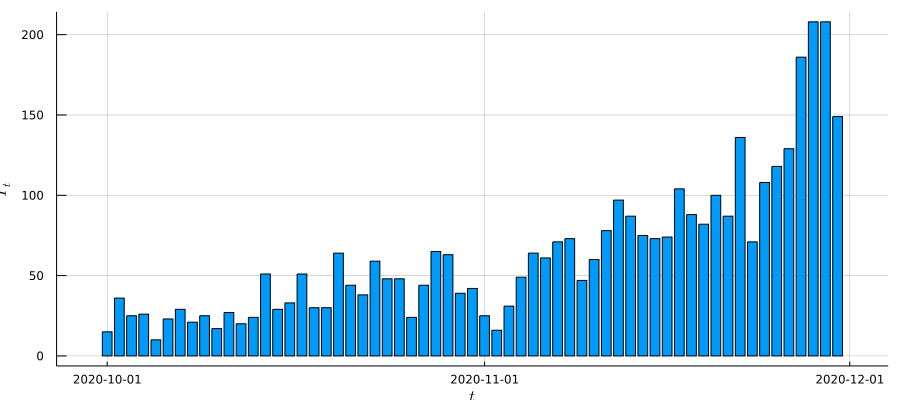

In [42]:
bar(fechauy,Iuy, xlabel=L"t", ylabel=L"I_t", legend=:none)

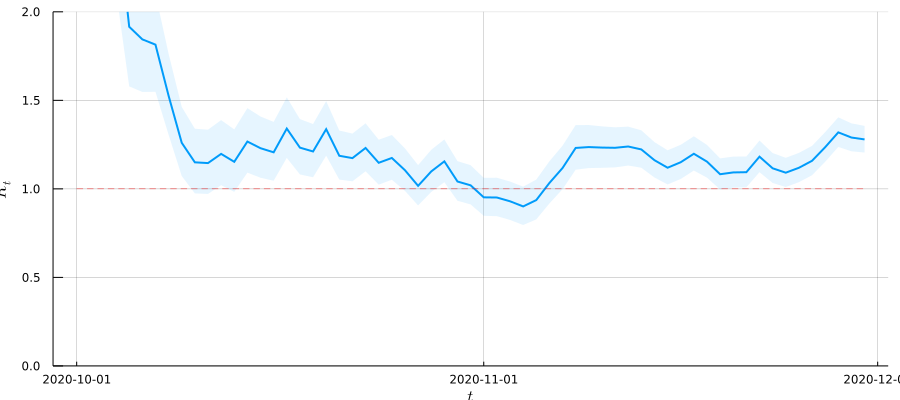

In [43]:
R,Rl,Ru,a,b, Lambda =epi_estim_R(Iuy)

plot(fechauy,R, ylim=(0,2), lw=2, legend=:none, xlabel = L"t", ylabel=L"R_t", ribbon=(R-Rl,Ru-R), fillalpha=0.1)
plot!(fechauy,ones(size(fechauy)), color=:red, ls=:dash, lw=0.4)

## Proyección a corto plazo

Para realizar una proyección a corto plazo de la incidencia, proponemos propagar siguiendo la dinámica ya descrita.

**Nota:** Como el valor de $R_t$ es algo ruidoso, tomaremos el $R_t$ promedio en una ventana (ej: 3 dias) como el $R$ futuro de la epidemia, y simulamos en base a ello.

Realizando $n=10000$ repeticiones de la simulación se construyen intervalos de confianza de la incidencia diaria para los próximos $T=30$ días por ejemplo.

In [44]:
incidence_0 = Iuy
ventana = 7

#filtro una pasada mas del R
R0,Rl,Ru,a0,b0, Lambda = epi_estim_R(incidence_0)
Rfuturo = R0[end-ventana+1:end]

dias = 31
reps = 10000

println("R efectivo=$(geomean(Rfuturo))")


median,lower,upper = compute_prediction(Rfuturo,incidence_0,dias,reps, si_covid);


R efectivo=1.2103342201082585


### Resultados

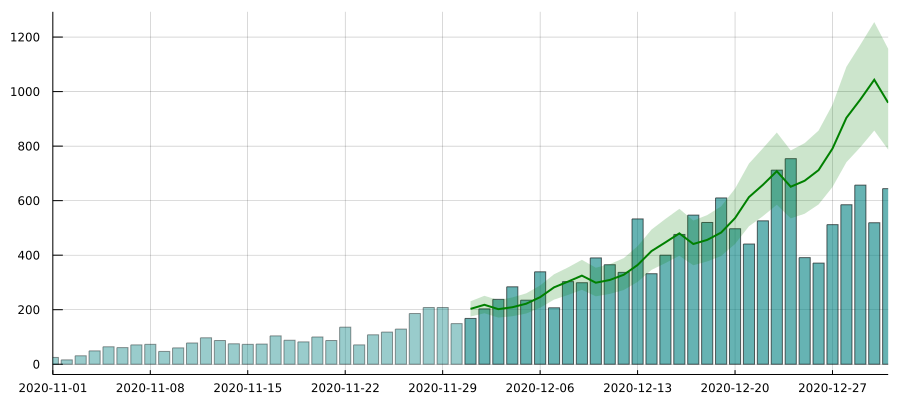

In [46]:
p=plot(legend=:none)

bar!(p,fechauy,Iuy, color=:teal, alpha=0.4)
bar!(p,rango_validacion,Ivalid, color=:teal, alpha=0.6)

plot!(p,fecha2,median, ribbon=(median-lower,upper-median),lw=2, color=:green, fillalpha=0.2, xlims=(Date(2020,11,1), Date(2020,12,31)), xticks=Date(2020,11,1):Dates.Day(7):Date(2020,12,31))